In [13]:
import h5py
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import argparse
from pathlib import Path
import matplotlib.cm as cm

import glob
import netCDF4
# from dea_tools.plotting import xr_animation
import os
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import odc.geo.xr

In [3]:
def paths_to_datetimeindex(paths, string_slice=(0, 10), form='%Y%m'):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.
    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).
    Returns
    -------
    A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
    from the file paths provided by `paths`.
    """
    date_strings = [os.path.basename(i)[slice(*string_slice)]
                    for i in paths]
    return pd.to_datetime(date_strings, format=form)

In [4]:
# Load and sort filelist by time

filelist=[]
path = '/g/data/jk72/MIZ/ICESat2/'
print("Finding files")
for file in Path(path).rglob('*.h5'):
    filelist.append(file)

filelist = sorted(filelist, key=lambda i: int(os.path.splitext(os.path.basename(i)[9:17])[0]))
print(f"Processing {len(filelist)} files")

# extract dimensions from top layer of h5 file
dims = xr.open_dataset(filelist[0])

Finding files
Processing 42 files


In [5]:
# Create time index

time_var = xr.Variable('time', paths_to_datetimeindex(filelist,
                                                      string_slice=(9,15), form='%Y%m'))

# Concat individual monthly data

ds = xr.concat([xr.open_dataset(i, group='monthly').squeeze() for i in filelist],
                        dim=time_var)

# Apply dimensions

ds = ds.assign_coords({'grid_x':dims['grid_x'], 'grid_y':dims['grid_y']})

# Calculate monthly mean

mean = ds['mean_fb'].groupby('time.month').mean('time')

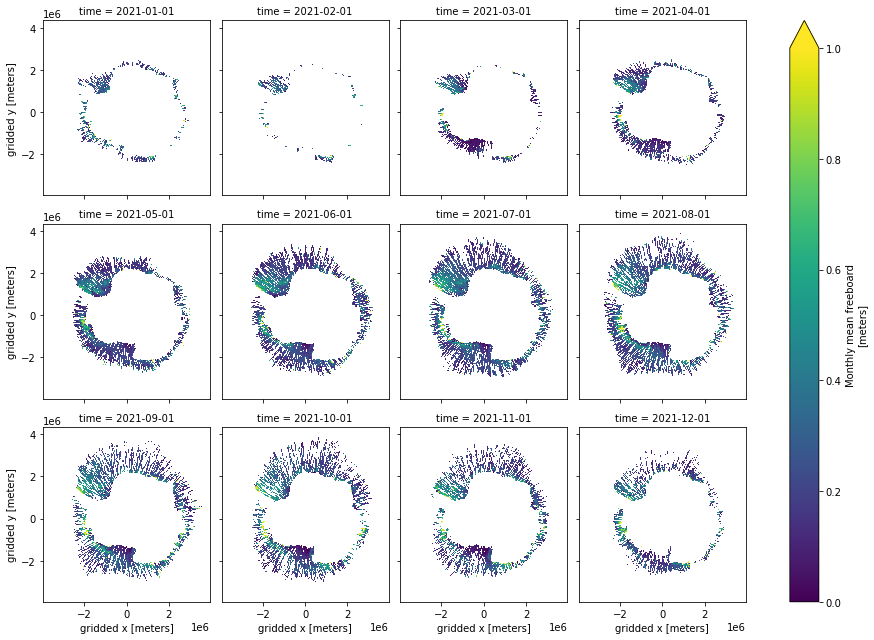

In [6]:
# Plot one year of monthly freeboard

ds['mean_fb'].sel(time=slice("2021-01-01","2021-12-31")).plot(col="time", col_wrap=4, vmax=1)
plt.save_fig('/g/data/jk72/sc0554/ATL20_mean_fb_2021')

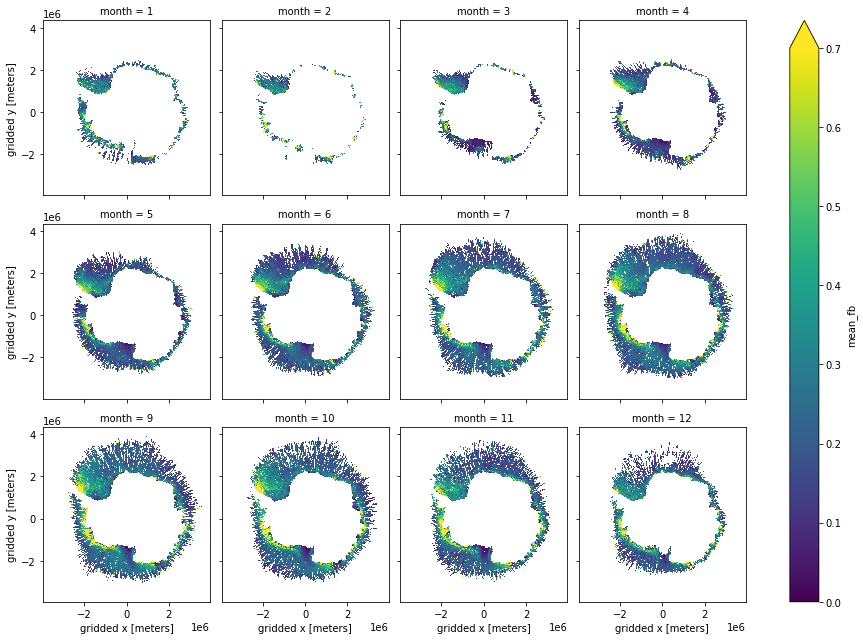

In [7]:
# Plot monthly all time means

mean.plot(col="month", col_wrap=4, vmax=0.7)
plt.savefig('/g/data/jk72/sc0554/ATL20_alltime_monthly_mean_fb.png')

In [12]:
# Save data

ds.to_netcdf('/g/data/jk72/sc0554/ATL20.nc')

In [13]:
# Open and verify

xr.open_dataset('/g/data/jk72/sc0554/ATL20.nc')['time']

<xarray.DataArray 'time' (time: 42)>
array(['2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2019-02-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000', '2019-09-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-04-01T00:00:00.000000000', '2020-05-01T00:00:00.000000000',
       '2020-06-01T00:00:00.000000000', '2020-07-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-10-01T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-02-01T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2021-05-01T00:00:00.000000000',
       '2021-06-01T00:00:00.000000000', '2021-07-01T00:00:00.000000000',
       '2021-08-01T00:00:00.000000000', '2021-09-01T00:00:00.000000000',
       '2021-10-01T00:00:00.000000000', '2021-11-01T00:00:00.000000000',
       '2021-12-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2022-02-01T00:00:00.000000000', '2022-03-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-10-01 2018-11-01 ... 2022-03-01

## Create image files

In [18]:
# Open data
path = '/g/data/jk72/sc0554/ATL20.nc'
data_dir = '/g/data/jk72/MIZ'

ds = xr.open_dataset(path)

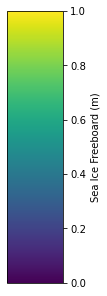

In [14]:
# Create legend

norm=colors.Normalize(vmin=0,vmax=1)
fig=plt.figure(figsize=(1,5))
ax=plt.subplot()
cb=fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap='viridis'),
    label='Sea Ice Freeboard (m)',
    cax=ax,
    #aspect=2.5
)
# cb.set_ticks([15,30,45,60,75,90,100])

# plt.savefig(f'{data_dir}/tracker_files/sea_ice_freeboard_legend.png',
#                bbox_inches='tight', transparent="True")

/g/data/jk72/sc0554/miniconda3/envs/sea-ice-tracker/lib/python3.9/site-packages/odc/geo/_xr_interop.py:266: UserWarning: grid_mapping=../crs: ../grid_x ../crs: ../grid_y is not pointing to valid coordinate
  warnings.warn(


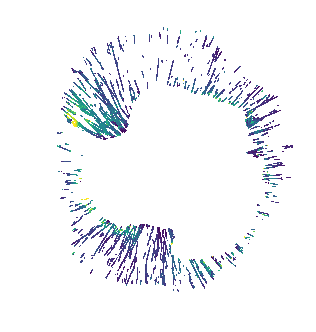

In [19]:
# Plot example image

cm=plt.get_cmap("viridis")
colored_xr = ds.isel(time=0)['mean_fb'].odc.colorize(cmap=cm, vmin=0, vmax=1)
png_image=Image.fromarray(colored_xr.values,mode="RGBA")
png_image

In [20]:
# Create images

cm=plt.get_cmap("viridis")

for time in ds['time']:
    datetime = pd.to_datetime(time.values)
    colored_xr=ds['mean_fb'].sel(time=time).odc.colorize(cmap=cm, vmin=0, vmax=1)
    png_image=Image.fromarray(colored_xr.values,mode="RGBA")
    png_image.save(
        f'{data_dir}/tracker_files/ATL20/ATL20_monthly_fb_{datetime.year}_{datetime.month}.png'
    )